In [ ]:
# Importing all the required libraries
import os
from io import BytesIO
import tarfile
import tempfile
import cv2
from six.moves import urllib
from copy import deepcopy
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from IPython.display import Image as IMG

In [ ]:
%tensorflow_version 2.x # Settinng tensorflow version to 2.x as 1.x is not supported by google colab
import tensorflow as tf # Importing tensorflow

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
import numpy as np
import tensorflow as tf
import tarfile
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Define constants
MODEL_INPUT_SIZE = 513  # Default input size for DeepLab
FROZEN_GRAPH_NAME = 'frozen_inference_graph.pb'

LABELS = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

# ===================== DEEPLAB MODEL =====================
class SemanticSegmentationModel:
    """Handles loading and inference of the DeepLab model."""

    def __init__(self, model_path):
        """Loads the DeepLab model from a tar file."""
        self.graph = tf.Graph()

        # Extract the frozen graph
        graph_def = self._extract_graph(model_path)
        if graph_def is None:
            raise ValueError("Model's frozen graph could not be found in the tar file.")

        # Load graph into TensorFlow session
        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')

        self.session = tf.compat.v1.Session(graph=self.graph)
        self.input_tensor_name = 'ImageTensor:0'
        self.output_tensor_name = 'SemanticPredictions:0'

    def _extract_graph(self, tar_path):
        """Extracts the frozen inference graph from the tar file."""
        with tarfile.open(tar_path, 'r') as tar_file:
            for tar_info in tar_file.getmembers():
                if FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                    file_handle = tar_file.extractfile(tar_info)
                    return tf.compat.v1.GraphDef.FromString(file_handle.read())
        return None

    def predict(self, image):
        """Runs inference on the input image.

        Args:
            image: A PIL.Image object.

        Returns:
            A tuple containing:
            - resized_image: The resized version of the input image.
            - segmentation_map: The predicted segmentation map.
        """
        original_width, original_height = image.size
        resize_ratio = MODEL_INPUT_SIZE / max(original_width, original_height)
        target_size = (int(original_width * resize_ratio), int(original_height * resize_ratio))

        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        seg_map = self.session.run(
            self.output_tensor_name,
            feed_dict={self.input_tensor_name: [np.asarray(resized_image)]}
        )[0]

        return resized_image, seg_map

# ===================== VISUALIZATION FUNCTIONS =====================
def create_colormap():
    """Generates a colormap for segmentation visualization."""
    colormap = np.zeros((256, 3), dtype=int)
    indices = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((indices >> channel) & 1) << shift
        indices >>= 3

    return colormap

def map_labels_to_colors(label_map):
    """Applies the colormap to a segmentation label map."""
    colormap = create_colormap()
    if np.max(label_map) >= len(colormap):
        raise ValueError("Label value exceeds the colormap range.")
    return colormap[label_map]

def visualize_segmentation(image, segmentation_map):
    """Displays the input image, segmentation map, and overlay."""
    colormap_applied = map_labels_to_colors(segmentation_map)

    plt.figure(figsize=(15, 5))
    grid = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

    # Input image
    plt.subplot(grid[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title("Input Image")

    # Segmentation map
    plt.subplot(grid[1])
    plt.imshow(colormap_applied)
    plt.axis('off')
    plt.title("Segmentation Map")

    # Overlay
    plt.subplot(grid[2])
    plt.imshow(image)
    plt.imshow(colormap_applied, alpha=0.6)
    plt.axis('off')
    plt.title("Segmentation Overlay")

    plt.tight_layout()
    plt.show()

# ===================== MAIN EXECUTION =====================
if __name__ == "__main__":
    # Specify the path to the model and input image
    model_tarball = './deeplab_model.tar.gz'  # Replace with your model path
    input_image_path = './input_image.jpg'   # Replace with your image path

    # Load the model
    model = SemanticSegmentationModel(model_tarball)

    # Load and preprocess the input image
    input_image = Image.open(input_image_path)

    # Perform inference
    resized_image, seg_map = model.predict(input_image)

    # Visualize results
    visualize_segmentation(resized_image, seg_map)



In [ ]:
# Downloading the mobilenetv2 model form tensorflow site.
MODEL_NAME = 'mobilenetv2_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.io.gfile.makedirs(model_dir)

download_path = os.path.join(model_dir,_TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME], #using urllib to download
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')


downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


In [ ]:
# Creating a function which will call the method run from previously define class.
def run_visualization():
  """Inferences DeepLab model and visualizes result."""
  try:
    original_im = Image.open(IMAGE_NAME)
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image')
  resized_im, seg_map = MODEL.run(original_im)
  vis_segmentation(resized_im, seg_map)
  return resized_im, seg_map

running deeplab on image
1920 1080
Resize Ratio - 0.2671875
(513, 288)


<ipython-input-15-4a741b14f78e>:50: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)


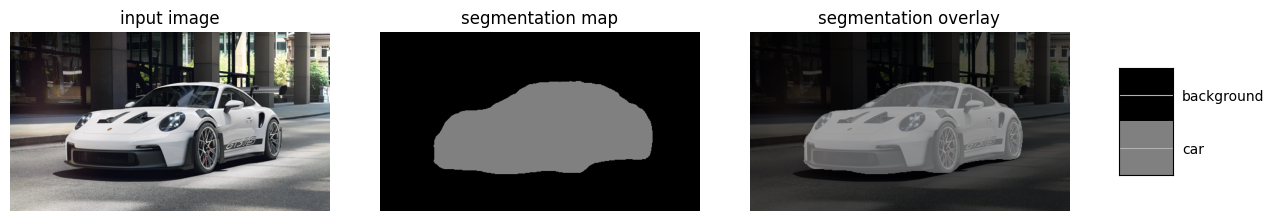

In [ ]:
IMAGE_NAME = 'anyimage.jpg' # Pass any image.
resized_im, seg_map = run_visualization() # Calling the above function.

In [ ]:
LABEL_NAMES # Checking the label names.

array(['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
       'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
       'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
       'tv'], dtype='<U11')

In [ ]:
LABEL_NAMES[7] # Label for car is 7.

'car'

Convert pil image to numpy array

In [ ]:
print(type(resized_im))
numpy_image = np.array(resized_im) # Convert PIL image to numpy array.

<class 'PIL.Image.Image'>


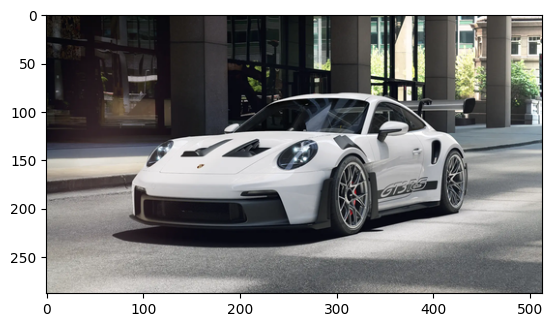

In [ ]:
plt.imshow(numpy_image) # Checking the image.

In [ ]:
person_not_person_mapping = deepcopy(numpy_image)  # Seperating background & foreground classes using Segmap.
person_not_person_mapping[seg_map != 7] = 0        # Replacing the pixel intensity values to 0 where the car class is not found in segmentation map  i.e changing background to balck.
person_not_person_mapping[seg_map == 7] = 255      # Replacing the pixel intensity values to 1 where the car calss is found in segmentation map i.e changing the foreground to white.

# Please note that if you have image with any other class then the class label to different value ex: for person it will be 15, for bird it will be 3.
# Refer above label names to find out the respective class and change the values accordingly.
# Else the segmentation map wont have proper values.

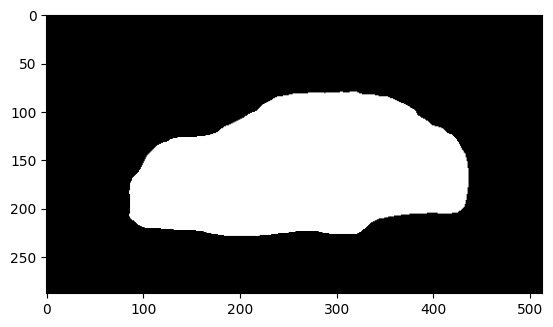

In [ ]:
plt.imshow(person_not_person_mapping) # Ploting the mapped image.

In [ ]:
np.unique(person_not_person_mapping) # checking the unique values of pixel instensity after changes.

array([  0, 255], dtype=uint8)

#

In [ ]:
orig_imginal = Image.open(IMAGE_NAME) # Reading the original image.
orig_imginal = np.array(orig_imginal) # Converting the image to an numpy array.

In [ ]:
orig_imginal.shape # Checking the dimensions of the original image.

(1080, 1920, 3)

In [ ]:
mapping_resized = cv2.resize(person_not_person_mapping, # Resizing the mapped image to the original image size.
                             (orig_imginal.shape[1],
                              orig_imginal.shape[0]),
                             Image.ANTIALIAS)

<ipython-input-31-2cdaca246d22>:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  Image.ANTIALIAS)


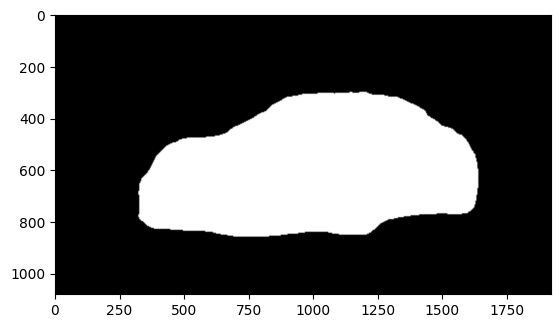

In [ ]:
plt.imshow(mapping_resized) # Checking the resized image.

In [ ]:
mapping_resized.shape

(1080, 1920, 3)

In [ ]:
np.unique(mapping_resized) # After resizing image to original size it adds up additional pixel values ranging from 0 to 255.

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

Otsu's Binarization

In [ ]:
gray = cv2.cvtColor(mapping_resized, cv2.COLOR_BGR2GRAY) # Converting mapped image to gray.
blurred = cv2.GaussianBlur(gray,(15,15),0) # Applying the gaussian blur effect.
ret3,thresholded_img = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) # Applying binarization based on Otsu's

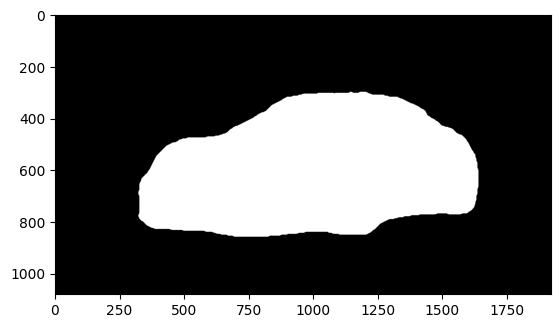

In [ ]:
plt.imshow(thresholded_img, cmap="gray") # Plotting the binarized image.

In [ ]:
thresholded_img.ndim # Checking the dimensions

2

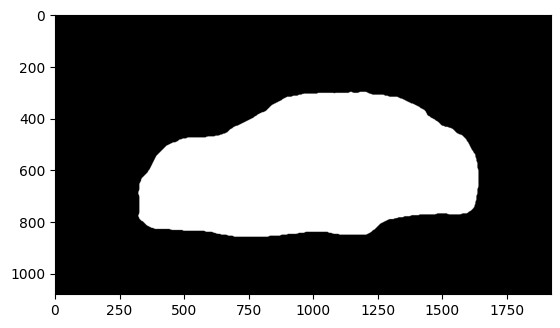

In [ ]:
mapping = cv2.cvtColor(thresholded_img, cv2.COLOR_GRAY2RGB) # Applying or converting the threshold image to RGB space.
plt.imshow(mapping) # Plotting the image.

In [ ]:
np.unique(mapping) # After applying the colors the pixel intensity  values are limited to 0 and 255 as per our segmented map.

array([  0, 255], dtype=uint8)

In [ ]:
blurred_original_image = cv2.GaussianBlur(orig_imginal,
                                          (251,251),
                                          0)
# Applying blur effect to entire original image.

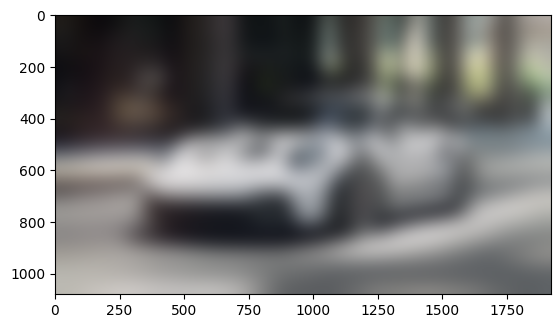

In [ ]:
plt.imshow(blurred_original_image) # checking the blur image.

In [ ]:
layered_image = np.where(mapping != (0,0,0),
                         orig_imginal,
                         blurred_original_image)
# The main part where we replace segmented map image where the pixel intensity values are not 0 i.e white with original image,
# and replace background where the pixel intensity values are 0 i.e black with the blured image.

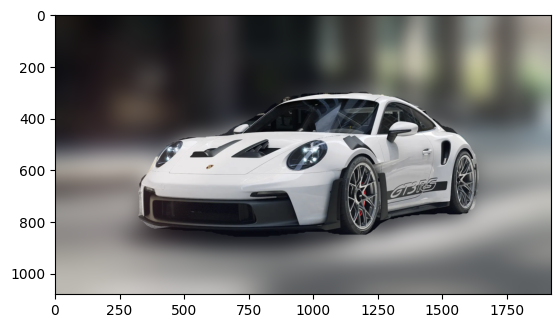

In [ ]:
plt.imshow(layered_image) # Plotting the bokhe image.

In [ ]:
im_rgb = cv2.cvtColor(layered_image, cv2.COLOR_BGR2RGB) # Saving the new bokeh image.
cv2.imwrite("Potrait_Image.jpg", im_rgb)

True

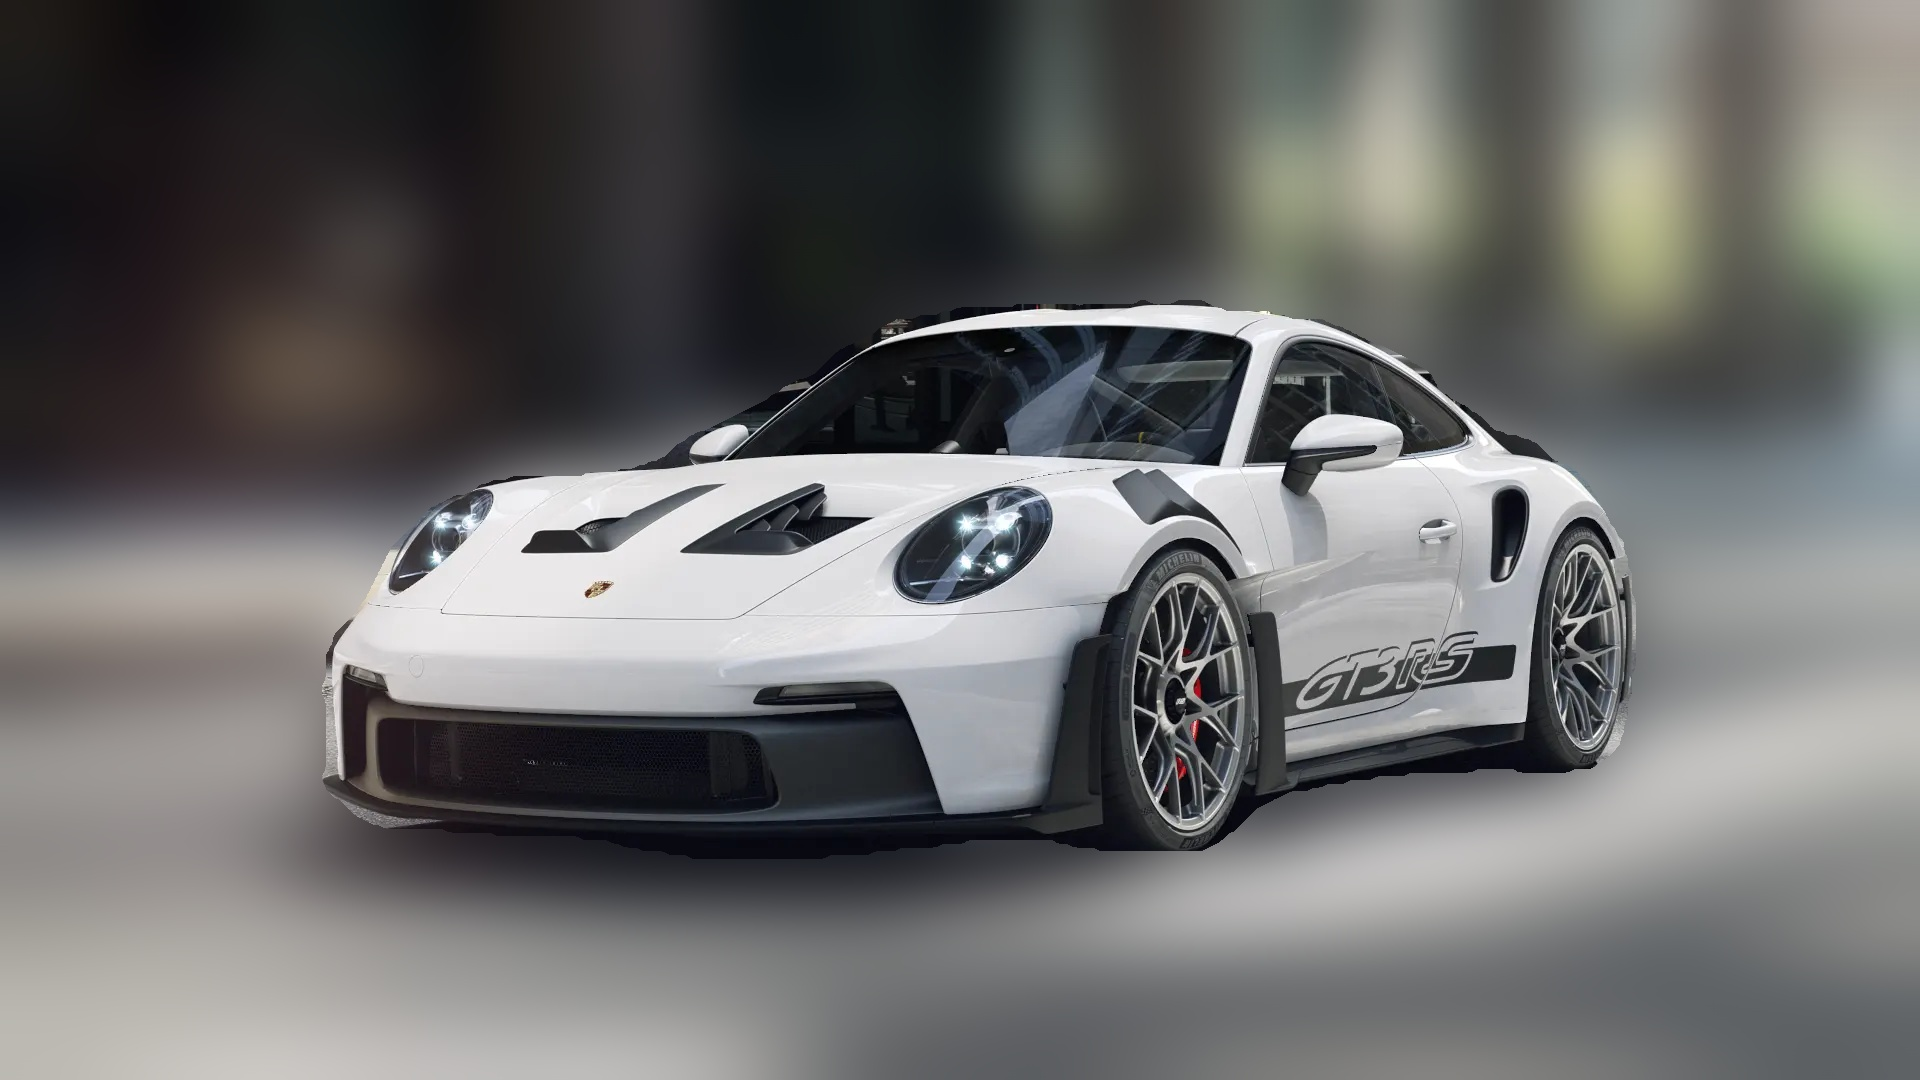

In [ ]:
IMG("Potrait_Image.jpg") # Viewing the saved image in orginal size.

**************************************************